#### 환경 설정

1. 필요한 라이브러리 다운

In [1]:
! pip install ultralytics
! pip incstall opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
### 모델 관련 ----
import ultralytics
from ultralytics import YOLO
# 제대로 설치되었는지 확인하는 코드
ultralytics.checks()
### 경로 설정 시 ----
import os
### 바운딩박스 생성 시 ----
from PIL import Image
### 데이터 증강 ----
import albumentations as A
from albumentations.pytorch import ToTensorV2
### 데이터 분리할 때 사용 ----
import random
import shutil
### yaml 파일 생성 ----
import yaml
#### 그림 그리고, 레이블링 할 때 ----
import cv2
import matplotlib.pyplot as plt
### 혹시 모르니까 설치하는 부분 ----
import pandas as pd
import numpy as np

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/112.6 GB disk)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2. 경로 설정

In [ ]:
### 데이터 ---- *나중에 없으면 만들도록 할 수 있음! 일단 정해만 두기
# 현재 데이터 있는 곳
base_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP" # 일단 AP로
# 데이터 분리해서 담아둘 곳 (train, val / image, label 분리)
to_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/DATA_AP/"

### YAML 파일 담을 곳 ----
yaml_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/YAML_AP/"

### 결과 파일 담을 곳 ----
results_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results"

In [ ]:
# 만들고 들어오기 귀찮아요,,,
paths = ["/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/DATA_AP",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/YAML_AP",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results"]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

#### 데이터 준비

1. 바운딩박스 만들기

In [ ]:
# 전체 파일 읽어오기
files_list = [file for file in os.listdir(base_path) if file.endswith(".csv")]

# 전체 파일 이름 읽어오기
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".csv")]
file_names[:5]

['0107-F-033Y0',
 '0024-F-014Y0',
 '0031-F-014Y0',
 '0101-F-022Y0',
 '0102-F-013Y0']

In [ ]:
# 한 장 가지고 진행한다고 생각 - 두 줄로 바운딩박스 만드는 함수
def create_bbox_2lines(line1, line2, width, height):
    # x, y 좌표 읽기
    x_coords = [line1[0], line1[2], line2[0], line2[2]]
    y_coords = [line1[1], line1[3], line2[1], line2[3]]

    # 최대, 최소
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # 중심, 크기
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    bb_width = (x_max - x_min) / width
    bb_height = (y_max - y_min) / height

    # 라벨
    class_id = 1 if int(line1[4]) in [1, 2] or int(line2[4]) in [1, 2] else 0

    return [class_id, x_center, y_center, bb_width, bb_height]

# 한 장 전체
def create_bbox_pic(file_name, width, height):
    bb_csv_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{file_name}.csv"
    lines = pd.read_csv(bb_csv_path, header = None)
    yolo_boxes = []
    class_ids = []
    for i in range(0, len(lines)-1, 2):
        yolo_box = create_bbox_2lines(
            lines.iloc[i].tolist(),
            lines.iloc[i+1].tolist(),
            width, height)
        yolo_boxes.append(yolo_box)
        class_ids.append(yolo_box[0]) # 비정상 데이터 따로 가져오기 위해 class_id만 따로 모아두기

    # 저장하기
    txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{file_name}_cls.txt"
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(' '.join(map(str, box)) + '\n')

    # class_id 반환 (한 장에 대한 5개의 값)
    return class_ids

# 여러 장으로 확장
def make_bbox(file_names):
    abnormal_names = []
    for file_name in file_names: # 이름 하나 받아서

        # Width, Height 출력
        bb_image_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{file_name}.jpg"
        image = Image.open(bb_image_path)
        width, height = image.size

        # 한 장 전체에서 bounding box + class_id 확인
        class_ids = create_bbox_pic(file_name, width, height)

        # 비정상 데이터 모으기
        if 1 in class_ids:
            abnormal_names.append(file_name)

    return abnormal_names

In [ ]:
abnormal_names = make_bbox(file_names)

In [ ]:
abnormal_names # 10장

['0014-F-062Y0',
 '0021-F-079Y0',
 '0159-M-062Y0',
 '0220-F-069Y0',
 '0223-F-063Y0',
 '0238-F-067Y0',
 '0250-F-069Y0',
 '0277-F-050Y0',
 '0316-F-074Y0',
 '0430-M-060Y0']

추가) 데이터 증강

- 비정상인 사진들에 대해서만 진행 (10장 -> 310장 정도로)
  - 밝기, 대비 변화
  - 픽셀에 노이즈 추가
  - 흐림 효과
일단 요 정도만...

In [ ]:
# 증강 함수 정의
transform = A.Compose([
    A.RandomBrightnessContrast(p = 0.5), # 밝기, 대비 조절
    A.GaussNoise(var_limit = (10.0, 40.0), mean = 0, p=0.3), # 가우시안 노이즈
    A.MotionBlur(blur_limit = 3, p=0.2) # 블러
])

# 증강할 개수
n_augments = 30

# 증강 진행, 저장까지 - 1분 정도 소요
for file_name in abnormal_names:
    # 경로 설정
    image_path = os.path.join(base_path, f"{file_name}.jpg")
    txt_path = os.path.join(base_path, f"{file_name}_cls.txt")

    # 이미지 로드
    image = np.array(Image.open(image_path))

    # 이미지 증강
    for i in range(1, n_augments + 1):
        augmented = transform(image = image)
        augmented_image = augmented['image']

        # 이미지, 바운딩박스 저장
        new_name = f"{file_name}_a{i}"
        new_image_path = os.path.join(base_path, f"{new_name}.jpg")
        new_txt_path = os.path.join(base_path, f"{new_name}_cls.txt")

        cv2.imwrite(new_image_path, augmented_image)
        shutil.copyfile(txt_path, new_txt_path)

<ipython-input-31-a7117db8eed8>:4: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit = (10.0, 40.0), mean = 0, p=0.3), # 가우시안 노이즈


In [ ]:
# 전체 파일 읽어오기 - Again (증강한 데이터 추가)
files_list = [file for file in os.listdir(base_path) if file.endswith(".jpg")]

# 전체 파일 이름 읽어오기 - Again (증강한 데이터 추가)
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".jpg")]
len(file_names) # 700개라면 잘 진행된 것 !

700

2. 데이터 분리 (train,val / image, label)

In [ ]:
### 폴더 생성
# 이미지/ 라벨 분리
img_ = '.jpg'
label_ = '.txt'

# 저장 경로 만들기
folders_list = [os.path.join(to_path, 'train'),
                os.path.join(to_path, 'val'),
                os.path.join(to_path, 'train/images'),
                os.path.join(to_path, 'val/images'),
                os.path.join(to_path, 'train/labels'),
                os.path.join(to_path, 'val/labels')]

# 없으면 생성해주세용
for folder in folders_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
### 데이터 분리 - 1분 정도 소요
# 1. 데이터 섞고
random.shuffle(files_list)

# 2. Train/Test 분리
ratio = 0.8
train_list = files_list[: int(len(files_list) * ratio)]
test_list = files_list[int(len(files_list) * ratio) :]

# 3. File 이동
for i in train_list: # train
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'train/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_cls" + label_)), os.path.join(to_path, 'train/labels', (file_name + label_)))

for i in test_list: # test
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'val/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_cls" + label_)), os.path.join(to_path, 'val/labels', (file_name + label_)))

3. YAML 파일 만들기

In [ ]:
classes = []
for name in file_names:
    check_txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{name}_cls.txt"
    txt_file = pd.read_csv(check_txt_path, delimiter = ' ', header = None)
    classs = txt_file.iloc[:, 0] # 첫 열만 가져오기
    classes.extend(classs.tolist())

uniq_classes = pd.Series(classes)
uniq_classes.value_counts()

,count
0,3190
1,310


In [ ]:
# 폴더 없으면 만들기
if not os.path.exists(yaml_path):
    os.makedirs(yaml_path)

# 그 폴더로 들어가기
os.chdir(yaml_path)

# YAML 파일
data = dict()

#
data['train'] = os.path.join(to_path, 'train')
data['val'] = os.path.join(to_path, 'val')
data['test'] = os.path.join(to_path, 'val')

# 클래스 수
data['class'] = 2
data['names'] = ['Normal', 'Abnormal'] # 정상, 오른쪽으로 휨, 왼쪽으로 휨

# YAML 파일로 저장
with open('spine_ap.yaml', 'w') as f:
    yaml.dump(data, f)

#### Train

In [ ]:
from ultralytics import YOLO
# 모델 불러오기
model = YOLO('yolov8s.yaml')
# 학습 코드
results = model.train(data = 'spine_ap.yaml',
                      epochs = 40,
                      batch = 32, # 일반적으로 32
                      imgsz = (640, 400), # 입력 이미지 크기 고정 (세로로 긴 직사각형)
                      # - 사전에 안 고치고 진행할거면 이렇게 하면 됨 (근데 데이터 왜곡이 조금 있을 수도 있대)
                      device = 0, # 0이 GPU
                      patience = 5, # 성능 향상이 없는 경우 기다릴 epoch
                      name = 'trained_ap', # 저장할 이름
                      project = results_path)

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=spine_ap.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 400), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=trained_ap, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True,

train: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/DATA_AP/train/labels.cache... 560 images, 0 backgrounds, 0 corrupt: 100%|██████████| 560/560 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 4.7±4.9 ms, read: 104.4±94.6 MB/s, size: 1767.1 KB)


val: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/DATA_AP/val/labels.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      7.08G      5.011      4.292      4.148        135        640: 100%|██████████| 18/18 [00:43<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        140        700          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.89G      3.696      3.264      3.785        156        640: 100%|██████████| 18/18 [00:29<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        140        700          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      6.87G      2.931      2.851      3.098        166        640: 100%|██████████| 18/18 [00:31<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

                   all        140        700    0.00203      0.103    0.00123   0.000277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.87G      2.597      2.455      2.547        108        640: 100%|██████████| 18/18 [00:30<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        140        700   0.000546     0.0287   0.000303   5.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      6.87G      2.412      2.273       2.28        143        640: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        140        700     0.0072      0.432    0.00618    0.00319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.85G      2.262      1.943      2.081        197        640: 100%|██████████| 18/18 [00:31<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all        140        700      0.622     0.0946      0.061     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.87G      2.053      1.729       1.93        132        640: 100%|██████████| 18/18 [00:31<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        140        700       0.79      0.294      0.346      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.87G      1.857      1.491      1.763        151        640: 100%|██████████| 18/18 [00:31<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        140        700      0.851      0.372      0.432      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      6.87G      1.802      1.414      1.724        121        640: 100%|██████████| 18/18 [00:31<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        140        700      0.508      0.377      0.446      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.87G      1.742      1.341      1.661        134        640: 100%|██████████| 18/18 [00:33<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        140        700      0.889      0.373      0.468      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.87G      1.659      1.301      1.608        123        640: 100%|██████████| 18/18 [00:33<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all        140        700      0.352      0.497      0.491       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      6.87G      1.601      1.238      1.553        155        640: 100%|██████████| 18/18 [00:32<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        140        700      0.422      0.508      0.513      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.87G      1.513       1.13      1.466        200        640: 100%|██████████| 18/18 [00:32<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        140        700      0.469       0.57      0.554      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.87G      1.486       1.15      1.492        156        640: 100%|██████████| 18/18 [00:31<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        140        700      0.679      0.591       0.71      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      6.87G      1.414      1.042      1.426        134        640: 100%|██████████| 18/18 [00:32<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        140        700      0.676      0.706      0.726      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.87G      1.354      1.018      1.394        108        640: 100%|██████████| 18/18 [00:31<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        140        700      0.723      0.734      0.777      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      6.87G      1.371      1.012      1.412        146        640: 100%|██████████| 18/18 [00:31<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all        140        700      0.777      0.696      0.759      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.87G      1.317     0.9588       1.35        132        640: 100%|██████████| 18/18 [00:31<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        140        700      0.775      0.719      0.801      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      6.87G      1.283     0.9009      1.344        168        640: 100%|██████████| 18/18 [00:34<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        140        700      0.758      0.739      0.796      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.87G      1.255     0.8893      1.327        140        640: 100%|██████████| 18/18 [00:31<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        140        700      0.804      0.696      0.821      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.87G      1.251     0.8612      1.296        142        640: 100%|██████████| 18/18 [00:30<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        140        700      0.787      0.739      0.853      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      6.86G      1.186     0.8345      1.262        167        640: 100%|██████████| 18/18 [00:32<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        140        700       0.82       0.71       0.85      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.87G      1.218     0.8433      1.285        118        640: 100%|██████████| 18/18 [00:31<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        140        700       0.82      0.816       0.88      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.87G      1.214     0.8182       1.29        142        640: 100%|██████████| 18/18 [00:33<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        140        700      0.879      0.902      0.916      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      6.86G      1.189     0.8059      1.279        168        640: 100%|██████████| 18/18 [00:34<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        140        700      0.914      0.779      0.918      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      6.87G      1.123     0.7558       1.23        183        640: 100%|██████████| 18/18 [00:33<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        140        700      0.859       0.84      0.905      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      6.87G      1.111     0.7483      1.233        125        640: 100%|██████████| 18/18 [00:31<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        140        700      0.857      0.822      0.901      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      6.87G      1.086     0.7086      1.208        142        640: 100%|██████████| 18/18 [00:31<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        140        700      0.871      0.855      0.942      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.87G      1.075     0.7057      1.204        131        640: 100%|██████████| 18/18 [00:32<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        140        700      0.883      0.849      0.938       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      6.87G      1.072     0.6962      1.207        123        640: 100%|██████████| 18/18 [00:30<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        140        700      0.868      0.878      0.923      0.698


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      6.77G     0.9925     0.6538      1.269         79        640: 100%|██████████| 18/18 [00:43<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        140        700      0.893      0.851       0.93      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      6.77G     0.9634     0.6227      1.224         80        640: 100%|██████████| 18/18 [00:30<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        140        700      0.957        0.9      0.964      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      6.77G     0.9574      0.594      1.213         80        640: 100%|██████████| 18/18 [00:31<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all        140        700      0.916      0.914      0.945       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      6.77G     0.9196     0.5772      1.184         80        640: 100%|██████████| 18/18 [00:31<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        140        700      0.928      0.898      0.937      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      6.77G     0.9017     0.5648      1.204         80        640: 100%|██████████| 18/18 [00:31<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        140        700      0.956      0.928      0.962       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      6.77G     0.8763     0.5531      1.196         80        640: 100%|██████████| 18/18 [00:30<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        140        700      0.951      0.907      0.958      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      6.77G      0.869     0.5398      1.174         80        640: 100%|██████████| 18/18 [00:30<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        140        700      0.942      0.929      0.967      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      6.77G      0.847     0.5245      1.153         79        640: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all        140        700      0.962      0.934      0.973      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.77G      0.831     0.5159      1.143         80        640: 100%|██████████| 18/18 [00:31<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        140        700      0.947      0.929      0.973      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      6.77G     0.8089     0.5108       1.14         80        640: 100%|██████████| 18/18 [00:29<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        140        700      0.976      0.921      0.969      0.812



40 epochs completed in 0.431 hours.
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


                   all        140        700      0.963      0.935      0.973      0.816
                Normal        140        645       0.98      0.925      0.988      0.783
              Abnormal         55         55      0.945      0.944      0.959      0.848
Speed: 0.4ms preprocess, 4.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_AP/Results/trained_ap



0: 608x640 2 Yochoos, 85.2ms
Speed: 5.9ms preprocess, 85.2ms inference, 2.7ms postprocess per image at shape (1, 3, 608, 640)
2개의 박스가 만들어졌어용..


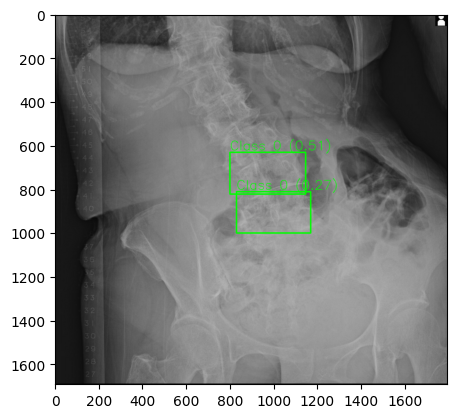

In [ ]:
### Inference
model_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/Results/trained_ap/weights/best.pt'
model = YOLO(model_path)

test_img_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/0021-F-079Y0.jpg'
test_img = cv2.imread(test_img_path)

# Inference
results = model(test_img)

for result in results:
    boxes = result.boxes
    print(f"{len(boxes)}개의 박스가 만들어졌어용..")
    confs = boxes.conf.cpu().numpy()
    coords = boxes.xyxy.cpu().numpy()

    # 상위 5개만
    top_5_idx = np.argsort(confs)[-5:][::-1]

    for index in top_5_idx:
        box = boxes[index]

        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        label = f"Class {cls} ({conf:.2f})"
        color = (0, 255, 0)
        cv2.rectangle(test_img, (x1, y1), (x2, y2), color, 5)
        cv2.putText(test_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

plt.imshow(test_img)
plt.show()

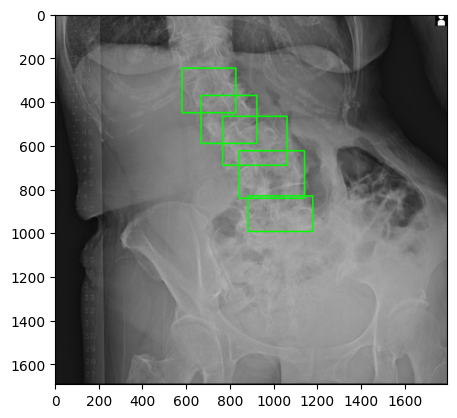

In [ ]:
### 실제랑 비교
# 첫 사진, 설명 경로
first_image_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/0021-F-079Y0.jpg'
first_bb_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/0021-F-079Y0_cls.txt"

# 이미지 불러오기
image = cv2.imread(first_image_path)
height, width, _ = image.shape

# 바운딩박스 그리기
with open(first_bb_path, "r") as f:
    lines = f.readlines()
for line in lines:
    parts = line.strip().split()
    class_id, x_center, y_center, box_w, box_h = map(float, parts)

    # YOLO 형식 → 픽셀 좌표 복원
    x_center *= width
    y_center *= height
    box_w *= width
    box_h *= height

    x1 = int(x_center - box_w / 2)
    y1 = int(y_center - box_h / 2)
    x2 = int(x_center + box_w / 2)
    y2 = int(y_center + box_h / 2)

    # 박스 그리기
    color = (0, 255, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 5)

plt.imshow(image)
plt.show()

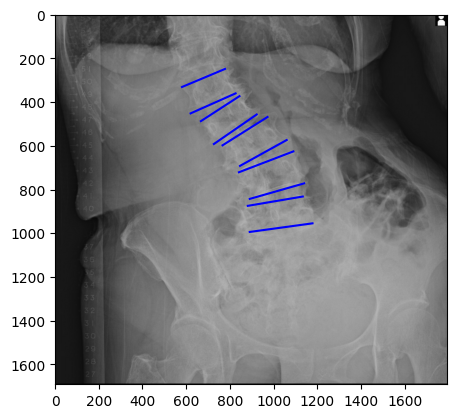

In [ ]:
# 첫 사진, 설명 경로
first_image_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/0021-F-079Y0.jpg'
first_text_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/0021-F-079Y0.csv"

# 이미지 불러오기
image = cv2.imread(first_image_path)

# 좌표 불러오기
points = pd.read_csv(first_text_path, header = None)
points = points.drop(4, axis = 1)
points = points.values.tolist()

plt.imshow(image)
for (x1, y1, x2, y2) in points:
    plt.plot([x1, x2], [y1, y2], 'b-')
plt.show()